In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [2]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    os.remove(temp_filename)
    return ela_image
  
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 98).resize([256,256])).flatten() / 255.0

In [3]:
real_dir = r"D:\dungnd\data\DATA_USB\MyOwnData\Real"
fake_dir = r"D:\dungnd\data\DATA_USB\MyOwnData\Fake"

print(len(os.listdir(real_dir)))
print(len(os.listdir(fake_dir)))

961
1148


In [4]:
X = []
y = []

for dirname, _, filenames in os.walk(real_dir):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path))
        y.append(1)
        if len(y) % 50 == 0:
            print(f'Processing {len(y)} images')

for dirname, _, filenames in os.walk(fake_dir):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path))
        y.append(0)
        if len(y) % 50 == 0:
            print(f'Processing {len(y)} images')

Processing 50 images
Processing 100 images
Processing 150 images
Processing 200 images
Processing 250 images
Processing 300 images
Processing 350 images
Processing 400 images
Processing 450 images
Processing 500 images
Processing 550 images
Processing 600 images
Processing 650 images
Processing 700 images
Processing 750 images
Processing 800 images
Processing 850 images
Processing 900 images
Processing 950 images
Processing 1000 images
Processing 1050 images
Processing 1100 images
Processing 1150 images
Processing 1200 images
Processing 1250 images
Processing 1300 images
Processing 1350 images
Processing 1400 images
Processing 1450 images
Processing 1500 images
Processing 1550 images
Processing 1600 images
Processing 1650 images
Processing 1700 images
Processing 1750 images
Processing 1800 images
Processing 1850 images
Processing 1900 images
Processing 1950 images
Processing 2000 images
Processing 2050 images
Processing 2100 images


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = to_categorical(y_train, 2)

y_test = to_categorical(y_test, 2)
X_train = X_train.reshape(-1, 256, 256, 3)
X_test = X_test.reshape(-1, 256, 256, 3)

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

1687 1687
422 422


In [13]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid', activation = 'relu', input_shape = (256, 256, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid', activation = 'relu'))
   
    model.add(Conv2D(filters = 32, kernel_size = (7, 7), padding = 'valid', activation = 'relu'))

    model.add(MaxPooling2D(pool_size = (2, 2)))
   
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))

    model.summary()
    return model

In [14]:
model = build_model()
epochs = 100
batch_size = 64
init_lr = 1e-5
optimizer = Adam(learning_rate = init_lr)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint = ModelCheckpoint("model_own_data.h5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 300, verbose = 0, mode = 'auto')

#%%
hist = model.fit(X_train, 
                 y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (X_test, y_test),
                 callbacks = [checkpoint, early_stopping])

#%%
model.save('model_own_data_best.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 conv2d_8 (Conv2D)           (None, 246, 246, 32)      50208     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 123, 123, 32)      0         
                                                                 
 flatten_2 (Flatten)         (None, 484128)            0         
                                                      

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 650s 24s/step - loss: 0.6902 - accuracy: 0.4695 - val_loss: 0.6856 - val_accuracy: 0.5261
Epoch 2/100
27/27 [==============================] - 458s 17s/step - loss: 0.6764 - accuracy: 0.5922 - val_loss: 0.6691 - val_accuracy: 0.6706
Epoch 3/100
27/27 [==============================] - 470s 17s/step - loss: 0.6491 - accuracy: 0.7054 - val_loss: 0.6434 - val_accuracy: 0.6754
Epoch 4/100
27/27 [==============================] - 439s 16s/step - loss: 0.6202 - accuracy: 0.6912 - val_loss: 0.6160 - val_accuracy: 0.6659
Epoch 5/100
27/27 [==============================] - 445s 17s/step - loss: 0.5959 - accuracy: 0.7078 - val_loss: 0.6054 - val_accuracy: 0.6540
Epoch 6/100
27/27 [==============================] - 442s 16s/step - loss: 0.5800 - accuracy: 0.7137 - val_loss: 0.6112 - val_accuracy: 0.6564
Epoch 7/100
27/27 [==============================] - 453s 17s/step - loss: 0.5737 - accuracy: 0.7184 - val_loss: 0.5970 - val_accuracy: 0.6659
Epoch 8/100

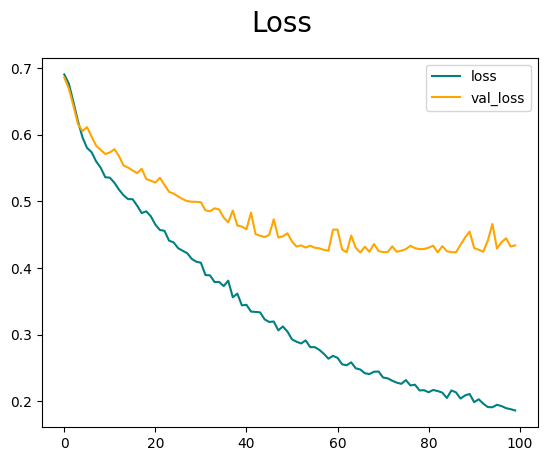

In [15]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

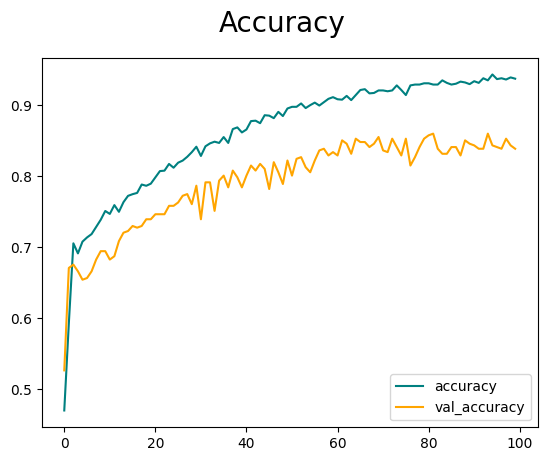

In [16]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

14/14 [==============================] - 19s 1s/step
Confusion Matrix:
[[205  23]
 [ 45 149]]
Precision: 0.8662790697674418
Recall: 0.7680412371134021
Accuracy: 0.8388625592417062


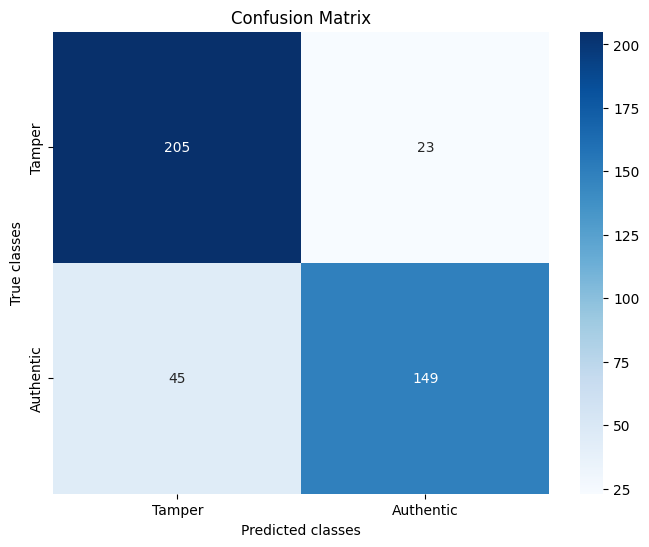

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
saved_model = load_model("E:\dungnd\GraduationProject\checkpoint\own_data_checkpoint\model_own_data_best.h5")

# Make predictions on the test data
y_pred = saved_model.predict(X_test)
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Precision, Recall, and Accuracy
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Tamper", "Authentic"], yticklabels=["Tamper", "Authentic"])
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.title('Confusion Matrix')
plt.show()

In [19]:
import pickle

# save history:
f = open('my_own_dataset_history.pckl', 'wb')
pickle.dump(hist.history, f)
f.close()

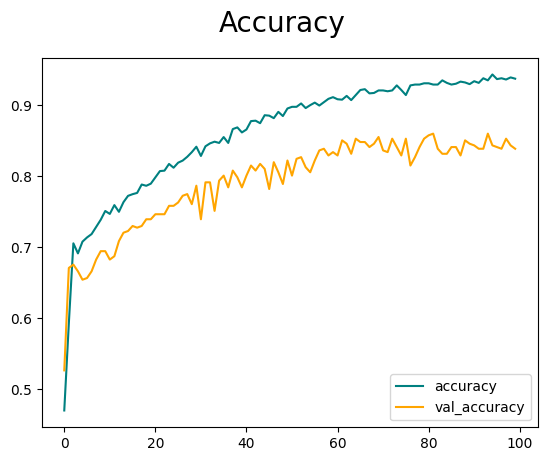

In [21]:
# retrieve history:    
f = open('E:\dungnd\GraduationProject\checkpoint\own_data_checkpoint\my_own_dataset_history.pckl', 'rb')
history = pickle.load(f)
f.close()


fig = plt.figure()
plt.plot(history['accuracy'], color='teal', label='accuracy')
plt.plot(history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

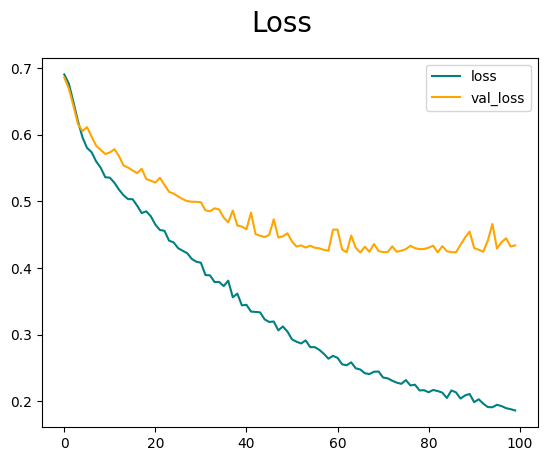

In [22]:
fig = plt.figure()
plt.plot(history['loss'], color='teal', label='loss')
plt.plot(history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()